In [12]:
import seaborn as sns
import numpy as np
import pandas as pd
import pandas_gbq as pd_gbq
import gc
from sklearn.decomposition import PCA, IncrementalPCA, KernelPCA
from matplotlib import pyplot as plt
#from google.cloud import automl_v1beta1 as automl
from google.cloud import bigquery
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import roc_auc_score, roc_curve, auc
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
from sklearn.preprocessing import StandardScaler
import pickle
from tqdm.auto import tqdm
import pyarrow as pa
import pyarrow.parquet as pq
import joblib
import glob
import lightgbm as lgb


In [13]:
'''
# This file contains models and plotting routines for the capstone project
# NEED: Default   = positive instance (1)
#       NoDefault = negative instance (0)
#
#
# Models Implemented: [
  'nb',
  'logistic',
 'svm',
 'decision_tree',
 'random_forest',
 'mlp_model',
 'xgb_model',
 'lgbm_model',
 'keras_model',
 'vot_soft_model',
 'vot_hard_model']
# 
'''

# things to do
# 1. GridSearchCV/RandomSearchCV for all models except the wrapper Keras model
# 2. Support Keras Model for GridSearchCV as well 
# 2.1 https://stackoverflow.com/questions/72351077/python-scikeras-valueerror-invalid-parameter-layers-for-estimator-kerasclas
# 2.2 https://towardsdatascience.com/scikeras-tutorial-a-multi-input-multi-output-wrapper-for-capsnet-hyperparameter-tuning-with-keras-3127690f7f28
# 2.3 https://www.adriangb.com/scikeras/stable/advanced.html


# https://towardsdatascience.com/are-you-using-the-scikit-learn-wrapper-in-your-keras-deep-learning-model-a3005696ff38
#import tensorflow as tf
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
#def create_model():
#    nn_model = tf.keras.models.Sequential()
#    nn_model.add(tf.keras.layers.Dense(units=n_features, activation='relu'))
#    nn_model.add(tf.keras.layers.Dense(units=n_features, activation='relu'))
#    nn_model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
#    nn_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',metrics=['accuracy'])
#    return nn_model
#model = KerasClassifier(build_fn=create_model,class_weight={0:0.25,1:0.75},epochs=1)
#history = model.fit(X_train,y_train)
#model.predict_proba(X_test)

# pre-processing
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder

# classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import GaussianNB

# https://xgboost.readthedocs.io/en/stable/get_started.html
import xgboost as xgb
# https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
import lightgbm as lgbm
import tensorflow as tf
import gc

# https://www.adriangb.com/scikeras/stable/migration.html#changes-to-your-code
# https://stackoverflow.com/questions/70066288/valueerror-the-estimator-kerasclassifier-should-be-a-classifier
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from scikeras.wrappers import KerasClassifier

# post-processing
from sklearn.metrics import classification_report,accuracy_score,f1_score
from sklearn.metrics import confusion_matrix,precision_score,recall_score
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.metrics import log_loss

# utils
from sklearn.utils import class_weight

# misc
from collections import namedtuple,defaultdict

# Big, standard packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import pandas as pd

# Pickle model
import pickle


In [14]:
df=pd.read_parquet("train_bucketted_grouped.parquet")
y=df['target']
df.drop('target',axis=1,inplace=True)

In [15]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage before optimization is: {:.2f} MB'.format(start_mem))
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df


In [16]:
X=reduce_mem_usage(df)

Memory usage before optimization is: 2751.09 MB
Memory usage after optimization is: 1399.18 MB
Decreased by 49.1%


In [17]:
del df
gc.collect

<function gc.collect(generation=2)>

In [18]:
X.drop('customer_ID',axis=1,inplace=True)

In [19]:
ft_importance=pd.DataFrame(index=X.columns)

In [20]:
scaler = StandardScaler()
X=scaler.fit_transform(X)

learning_rate=0.08,
                           n_estimators=200,
                           seed=45,
                           feature_fraction=0.20,
                           bagging_freq=10,
                           lambda_l2=2,
                           min_data_in_leaf=50,
                           boosting='dart',
                           num_threads=8,
                           early_stopping_rounds=100



learning_rate=1,
                          n_estimators=400,
                          seed=45,
                          feature_fraction=0.20,
                          bagging_freq=10,
                          lambda_l2=2,
                          min_data_in_leaf=100,
                          num_leaves=2000,
                          boosting='dart',
                          num_threads=8,
                          early_stopping_rounds=150

learning_rate=1,
                           n_estimators=200,
                           seed=45,
                           feature_fraction=0.20,
                           bagging_freq=10,
                           lambda_l2=2,
                           min_data_in_leaf=100,
                           num_leaves=1000,
                           boosting=dart,
                           num_threads=8,
                           early_stopping_rounds=150



In [24]:
# close all plots
plt.close('all')

# config globals
n_samples  =  8000
n_features =  1798
# used to generate trhe unbalanced dataset
frac_pos = 0.25 
frac_neg = 1.0 - frac_pos
# used in models 
class_weight_type='balanced'  


# Parameters for models
# KerasClassifier
n_hidden_layers_keras     = 3
n_neurons_per_layer_keras = 32
n_epochs_keras            = 64


# Datatypes
# cr = classification_report, cm = confusion_matrix
eval_report = namedtuple('eval_report',
                         ['cr','cm','acc','prec','recall','f1','roc','auc',
                          'log_loss'])

# Wrappers around non-sklearn classifiers
# Functions
def print_dashed(data):
    print('-'*80)
    print(data)
    print('-'*80)

def generate_fake_data(n_samples=100,n_features=40,frac_neg=0.5,frac_pos=0.5):
    X_train,X_test,y_train,y_test   = train_test_split(X,y,test_size=0.2)
    X_train,X_valid,y_train,y_valid = train_test_split(X_train,y_train,test_size=0.25)

    return X_train,X_valid,X_test,y_train,y_valid,y_test

def generate_real_data(path_to_data):
  df = pd.read_csv(path_to_data)
  df = df.dropna()
  df = df.iloc[:,2:]
  X_train = df.iloc[:,:-1].to_numpy()
  y_train = df.iloc[:,-1].to_numpy().astype('int64')

  # split into train (0.6),valid (0.2),test (0.2)
  X_train,X_test,y_train,y_test   = train_test_split(X_train,y_train,test_size=0.2,stratify=y_train)
  X_train,X_valid,y_train,y_valid = train_test_split(X_train,y_train,test_size=0.25,stratify=y_train)

  return X_train,X_valid,X_test,y_train,y_valid,y_test

def get_model(model_name):
  if (model_name == 'lr'):
    return LogisticRegression(penalty='l2',fit_intercept=True,
                               C=1.0,class_weight=class_weight_type,
                               max_iter=100,solver='newton-cg'
                               )
  if (model_name == 'svm'):
    return SVC(C=1.0,kernel='rbf',probability=True,
               class_weight=class_weight_type
                )
  if (model_name == 'dt'):
    return DecisionTreeClassifier(max_depth=9,class_weight=class_weight_type,min_samples_split=2)

  if (model_name == 'rf'):
    return RandomForestClassifier(class_weight=class_weight_type)

  if (model_name == 'kclf'):
    return KerasClassifier(model=create_keras_model,
                           model__reg_parm=1e-6,
                           class_weight=class_weights_dict,
                           epochs=n_epochs_keras,
                           verbose=1
                           )
    
  if (model_name =='xgb'):
    return xgb.XGBClassifier(objective="binary:logistic",
                              scale_pos_weight=n_neg_by_n_pos,
                             learning_rate=0.05,nthread=8,max_depth=15,subsample=0.5,
                             reg_lambda=2,
                             gamma=0.2,colsample_bytree=0.8,seed=45,n_estimators=100,
                             verbosity=2)
    
  if (model_name =='lgbm'):
    return lgbm.LGBMClassifier(class_weight=class_weight_type,
                               learning_rate=1,
                           n_estimators=200,
                           seed=45,
                           feature_fraction=0.20,
                           bagging_freq=10,
                           lambda_l2=2,
                           min_data_in_leaf=100,
                           num_leaves=1000,
                           boosting='dart',
                           num_threads=8,
                           early_stopping_rounds=150)

  if (model_name =='lgbm1'):
    return lgbm.LGBMClassifier(class_weight=class_weight_type,
                               learning_rate=1,
                          n_estimators=400,
                          seed=45,
                          feature_fraction=0.20,
                          bagging_freq=10,
                          lambda_l2=2,
                          min_data_in_leaf=100,
                          num_leaves=2000,
                          boosting='dart',
                          num_threads=8,
                          early_stopping_rounds=150
                              )

  if (model_name =='lgbm2'):
    return lgbm.LGBMClassifier(class_weight=class_weight_type,
                               learning_rate=0.08,
                           n_estimators=200,
                           seed=45,
                           feature_fraction=0.20,
                           bagging_freq=10,
                           lambda_l2=2,
                           min_data_in_leaf=50,
                           boosting='dart',
                           num_threads=8,
                           early_stopping_rounds=100
)

  if (model_name =='nb'):
    return GaussianNB()


def train_models(models_names,grid_search_type,grid_param_dict,
                 random_param_dict,cv,
                 X_train,y_train):
    
    # this functions returns models_list which contains models 
    # in the same sequence definede in models_names
    
    models_list = []
    best_params_list = []

    for model_name_ in models_names:
        model = get_model(model_name_)

        if grid_search_type == 'random':
          print_dashed('Doing RandomSearchCV for ' + model_name_)
          dd_ = random_param_dict[model_name_]
          rand_search = RandomizedSearchCV(model,dd_,cv=cv)
          rand_search.fit(X_train,y_train)
          models_list.append(rand_search.best_estimator_)
          best_params_list.append(rand_search.best_params_)

        if grid_search_type == 'grid':
          print_dashed('Doing GridSearchCV for ' + model_name_)
          dd_ = grid_param_dict[model_name_]
          grid_search = GridSearchCV(model,dd_,cv=cv)
          grid_search.fit(X_train,y_train)
          models_list.append(grid_search.best_estimator_)
          best_params_list.append(grid_search.best_params_)

        if grid_search_type == 'none':
          print_dashed('Training model ' + model_name_)
          model.fit(X_train,y_train)
          models_list.append(model)
          
    return models_list,best_params_list

def pred_models_proba(models_list,models_names,proba_names,X_test):
    pred_dict = {}
    for model_name in models_names:
        pred_dict[model_name] = {'ypred':None,'proba':None}
        
    for model,model_name in zip(models_list,models_names):
        print_dashed('Predicting model ' + model_name)
        y_pred  = model.predict(X_test)
        y_proba = None
        if (model_name in proba_names):
            y_proba = model.predict_proba(X_test) 
            
        pred_dict[model_name]['ypred'] = y_pred
        pred_dict[model_name]['proba'] = y_proba        
    return pred_dict

def eval_models(models_names,proba_names,y_true,pred_dict):
    eval_dict = {}
    
    for model_name in models_names:
        print_dashed('Evaluating model ' + model_name)
        y_pred = pred_dict[model_name]['ypred']
        
        cr     = classification_report(y_true,y_pred)
        cm     = confusion_matrix(y_true,y_pred)
        acc    = accuracy_score(y_true,y_pred)
        prec   = precision_score(y_true,y_pred)  
        recall = recall_score(y_true,y_pred)
        f1     = f1_score(y_true,y_pred)
        
        
        # make roc curve and auc scores
        roc    = None; auc    = None
        if model_name in proba_names:
            fpr_, tpr_, thresh_ = roc_curve(y_true,
                                            pred_dict[model_name]['proba'][:,1])
            
            log_loss_ = log_loss(y_true, pred_dict[model_name]['proba'][:,1])
            
            auc = roc_auc_score(y_true,pred_dict[model_name]['proba'][:,1])
            
            roc = {'fpr':fpr_,'tpr':tpr_,'thresh':thresh_}
        
        eval_dict[model_name] = eval_report(cr=cr,cm=cm,acc=acc,
                                            prec=prec,recall=recall,f1=f1,
                                            roc=roc,auc=auc,
                                            log_loss=log_loss_
                                            )
    return eval_dict

def disp_pct(ax):
  for p in ax.patches:
      value_ = round(p.get_height(),2)
      x = p.get_x() + p.get_width() / 2 - 0.05
      y = (p.get_y() + p.get_height())*1.01
      ax.annotate(value_, (x, y), size = 16)
  plt.show()

def plot_metrics(eval_dict,proba_names):
    figsize_x   = 16;     figsize_y = 8;
    label_size  = 14;     title_size = 16; 
    marker_size = 14;     linewidth = 2
        
    plot_list = ['accuracy','precision','recall','f1','log_loss']
    # the keys of the foll. dict are the items in plot_list
    # the values of the foll. dict are {'ax':ax,'data':yvalues}
    plot_dict = defaultdict(list)

    model_list   = []

    # For heat map, models on the Y axis, metrics on the X-axis
    heatmap_data = [] 

    for model_,value_ in eval_dict.items():
        model_list.append(model_)
        plot_dict['accuracy'].append(value_.acc)
        plot_dict['precision'].append(value_.prec)
        plot_dict['recall'].append(value_.recall)
        plot_dict['f1'].append(value_.f1)
        plot_dict['log_loss'].append(value_.log_loss)
       
        sns_row_ = [value_.acc,value_.prec,value_.recall,value_.f1]
        heatmap_data.append(sns_row_)
           
    sns.heatmap(heatmap_data,annot=True,xticklabels=plot_list[0:-1],yticklabels=model_list)
    plt.tight_layout()
    plt.savefig('models_metrics_heatmap.png')

    
        
    # plot over all models things in plot_list  
    for plot_ in plot_list:
        fig = plt.figure(figsize=(figsize_x,figsize_y))
        ax  = fig.gca()
        
        #ax.bar(model_list,plot_dict[plot_],'x-',markersize=marker_size,
        #        linewidth=linewidth)
        ax.bar(model_list,plot_dict[plot_])
        ax.set_title(plot_ +' for all models',fontsize=title_size)
        ax.set_xlabel('model',fontsize=label_size)
        ax.set_ylabel(plot_,fontsize=label_size)
        # annotate
        disp_pct(ax)
        

    # bar-graphs for values of each model
    bar_metric_list = ['accuracy','precision','recall','f1']
    for idx_model,model_ in enumerate(model_list):
      bar_metric_values = []
      for metric_ in bar_metric_list:
        bar_metric_values.append(plot_dict[metric_][idx_model])
      
      fig = plt.figure(figsize=(figsize_x,figsize_y))
      ax = fig.gca()
      ax.bar(bar_metric_list,bar_metric_values)
      ax.set_xlabel('Metric')
      ax.set_ylabel('Metric Value')
      ax.set_title('Metrics for model ' + model_)
      disp_pct(ax)

     

    # plot confusion matrix for all models
    for model_name,ev_rep in eval_dict.items():
      ax = plt.figure().gca()
      ax.set_title('Confusion matrix for model ' + model_name)
      sns.heatmap(ev_rep.cm,square=True, annot=True, fmt='d', cbar=False, 
            xticklabels=[0,1], yticklabels=[0,1])
      ax.set_ylabel('True class')
      ax.set_xlabel('Predicted class')
        
    # plot roc curves for probabilistic models
    figsize_x   = 9;     figsize_y = 8;
    for model_name,ev_rep in eval_dict.items():
        if model_name in proba_names:
            fig = plt.figure(figsize=(figsize_x,figsize_y))
            ax  = fig.gca()
            
            ax.set_title('PR curve for model ' + model_name +\
                         ' AUC=' + f'{ev_rep.auc:.3f}' 
                         ,fontsize=title_size)
            ax.set_xlabel('False positive rate ',fontsize=label_size)
            ax.set_ylabel('True positive rate',fontsize=label_size)
            
            # plot diagonal in dashed style
            ax.plot([0.0, 1.0],[0.0,1.0],'k--',linewidth=linewidth)
            ax.set_aspect('equal')
            
            # plot roc curve
            ax.plot(ev_rep.roc['fpr'],ev_rep.roc['tpr'],'bx-',
                    linewidth=linewidth)
       
def print_results(eval_dict):
    for key,value in eval_dict.items():
        print('-'*80)
        print('Model = ' + key)
        print('Accuracy = ' + str(round(value.acc,3)))
        print('Precision = '+ str(round(value.prec,3)))
        print('Recall = '   + str(round(value.recall,3)))
        print('F1 = '       + str(round(value.f1,3)))
        print('Log loss = ' + str(round(value.log_loss,3)))
        print('-'*80)
        
def create_keras_model(reg_parm=1e-4,n_hidden_layers_keras=n_hidden_layers_keras,
                       n_neurons_per_layer=n_neurons_per_layer_keras,
                       n_features=n_features):
    # https://lightrun.com/answers/adriangb-scikeras-sequential-model-doesnt-have-outputs
    # need to define input shape, otherwise it doesn't train
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input(shape=(n_features,)))

    for ilayer in range(n_hidden_layers_keras):
        model.add(tf.keras.layers.Dense(units=n_neurons_per_layer,
                                        activation='relu'))
        
    model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy',metrics=['accuracy'])
    
    return model

def save_models(models_list,models_names):
  for model_,name_ in zip(models_list,models_names):
    fname_ = name_+'.sav'
    with open(fname_,'wb') as fout:
      pickle.dump(model_,fout)
        
def load_model(model_name):
  with open(model_name+'.sav','rb') as fin:
    model_ = pickle.load(fin)
  return model_        

'''
X_train,X_valid,X_test,y_train,y_valid,y_test = generate_fake_data(n_samples=n_samples,
                                                                   n_features=n_features,
                                                                   frac_neg=frac_neg,
                                                                   frac_pos=frac_pos
                                                                   )
'''

X_train,X_valid,X_test,y_train,y_valid,y_test = generate_fake_data(X,y)

num_neg_instances = np.sum(y_train==0)
num_pos_instances = np.sum(y_train==1)
n_neg_by_n_pos    = num_neg_instances/num_pos_instances

class_weights_explicit = class_weight.compute_class_weight(class_weight=class_weight_type,
                                                           classes = np.unique(y_train),
                                                            y=y_train)
class_weights_dict = {0:class_weights_explicit[0],
                      1:class_weights_explicit[1]
                      }

In [25]:
#To download test set in csv
'''a=pd.DataFrame(X_test)
b=pd.DataFrame(y_test)

a.to_csv('test_without_target.csv')
b.to_csv('test_target.csv')'''

"a=pd.DataFrame(X_test)\nb=pd.DataFrame(y_test)\n\na.to_csv('test_without_target.csv')\nb.to_csv('test_target.csv')"

In [26]:
#---------------------Model Properties Begin --------------------
# 
'''
models_names = ['lr','svm','dt','rf',
                'xgb','lgbm','kclf','nb'
                ]
# list of models that support predict_proba
proba_names  = ['lr','svm','dt','rf',
                'xgb','lgbm','kclf','nb'
               ]
'''               
'''
# all models without kclf
#models_names = ['lr','svm','dt','rf','xgb','lgbm','nb']
#proba_names  = ['lr','svm','dt','rf','xgb','lgbm','nb']
'''

models_names = ['lr','nb','dt','xgb','lgbm','lgbm1','lgbm2']
proba_names  = ['lr','nb','dt','xgb','lgbm','lgbm1','lgbm2']


# Define parameters to grid search over
grid_param_dict = {}
grid_param_dict['lr']  = {'C':[0.1,1.0,10.0]}
grid_param_dict['svm'] = {'C':[0.1,1.0],'gamma':['auto']}
grid_param_dict['dt']  = {'max_depth':[9],'min_samples_split':[2]}
grid_param_dict['rf']  = {'max_depth':[4,5,6],'min_samples_split':[2,3,4]}
# https://xgboost.readthedocs.io/en/stable/python/python_api.html?highlight=xgbClassifier#xgboost.XGBClassifier                          
grid_param_dict['xgb']  = {'learning_rate':[0.05],
                           'nthread':[8],
                           'max_depth':[15],
                           'subsample':[0.5],
                           'lambda':[2],
                           'gamma':[0.2],
                           'colsample_bytree':[0.8],
                           'objective':['binary:logistic'],
                           'seed':[45],
                           'n_estimators':[100],
                           'verbosity':[2]}
# https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
grid_param_dict['lgbm'] = {'learning_rate':[0.08],
                           'n_estimators':[200],
                           'seed': [45],
                           'feature_fraction': [0.20],
                           'bagging_freq': [10],
                           'lambda_l2': [2],
                           'min_data_in_leaf':[50],
                           'boosting':['dart'],
                           'num_threads':[8],
                           'early_stopping_rounds':[100]
                           }

grid_param_dict['lgbm1'] = {'learning_rate':[1],
                           'n_estimators':[400],
                           'seed': [45],
                           'feature_fraction': [0.20],
                           'bagging_freq': [10],
                           'lambda_l2': [2],
                           'min_data_in_leaf':[100],
                           'num_leaves':[2000],
                           'boosting':['dart'],
                           'num_threads':[8],
                           'early_stopping_rounds':[150]
                           }

grid_param_dict['lgbm2'] = {'learning_rate':[1],
                           'n_estimators':[200],
                           'seed': [45],
                           'feature_fraction': [0.20],
                           'bagging_freq': [10],
                           'lambda_l2': [2],
                           'min_data_in_leaf':[100],
                           'num_leaves':[1000],
                           'boosting':['dart'],
                           'num_threads':[8],
                           'early_stopping_rounds':[150]
                           }
# How to use Keras Models with Grid and Random Search is explained below                             
#https://stackoverflow.com/questions/72189340/unable-to-perform-grid-search-for-models-receiving-more-than-one-input-keras
grid_param_dict['kclf'] = {'model__reg_parm':[1.0,1e-2,1e-4]}


random_param_dict = {}
random_param_dict['lr']   = {'C':np.linspace(0.1,1.0,10)}
random_param_dict['svm']  = {'C':np.linspace(0.1,1.0,10),'gamma':['auto']}
random_param_dict['dt']   = {'max_depth':np.arange(4,14),
                             'min_samples_split':np.arange(2,12)}
random_param_dict['rf']   = {'max_depth':np.arange(4,14),
                             'min_samples_split':np.arange(2,12)
                             }
random_param_dict['xgb']  = {'learning_rate':np.linspace(0.1,1.0,10)}
random_param_dict['lgbm'] = {'learning_rate':np.linspace(0.1,1.0,10),
                             'n_estimators':np.arange(50,100,5)}

# How to use Keras Models with Grid and Random Search is explained below                             
#https://stackoverflow.com/questions/72189340/unable-to-perform-grid-search-for-models-receiving-more-than-one-input-keras
random_param_dict['kclf'] = {'model__reg_parm':np.logspace(-4,-1,10)}

#------------------------Model properties end----------------------
# train models should return a single model
# add it to models list manually
models_list,best_params_list = train_models(models_names,'none',
                                            grid_param_dict,
                                            random_param_dict,
                                            5,X_train,y_train)
save_models(models_list,models_names)

--------------------------------------------------------------------------------
Training model lr
--------------------------------------------------------------------------------


/opt/conda/lib/python3.7/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


--------------------------------------------------------------------------------
Training model nb
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Training model dt
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Training model xgb
--------------------------------------------------------------------------------
[04:26:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4410 extra nodes, 22 pruned nodes, max_depth=15
[04:26:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4432 extra nodes, 12 pruned nodes, max_depth=15
[04:26:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4502 extra nodes, 20 pruned nodes, max_depth=15
[04:26:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4462 extra nodes, 30 pruned nodes, max_

/opt/conda/lib/python3.7/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


--------------------------------------------------------------------------------
Training model lgbm1
--------------------------------------------------------------------------------


/opt/conda/lib/python3.7/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


--------------------------------------------------------------------------------
Training model lgbm2
--------------------------------------------------------------------------------


/opt/conda/lib/python3.7/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


--------------------------------------------------------------------------------
Predicting model lr
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Predicting model nb
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Predicting model dt
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Predicting model xgb
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Predicting model lgbm
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Predic

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:2442: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:2442: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


--------------------------------------------------------------------------------
Evaluating model nb
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Evaluating model dt
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Evaluating model xgb
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Evaluating model lgbm
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Evaluating model lgbm1
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Eva

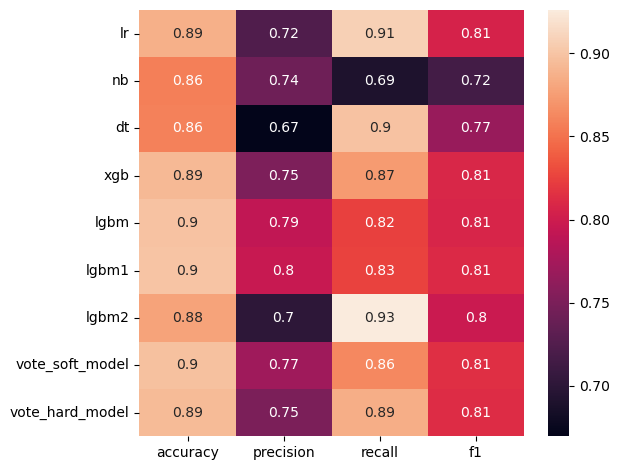

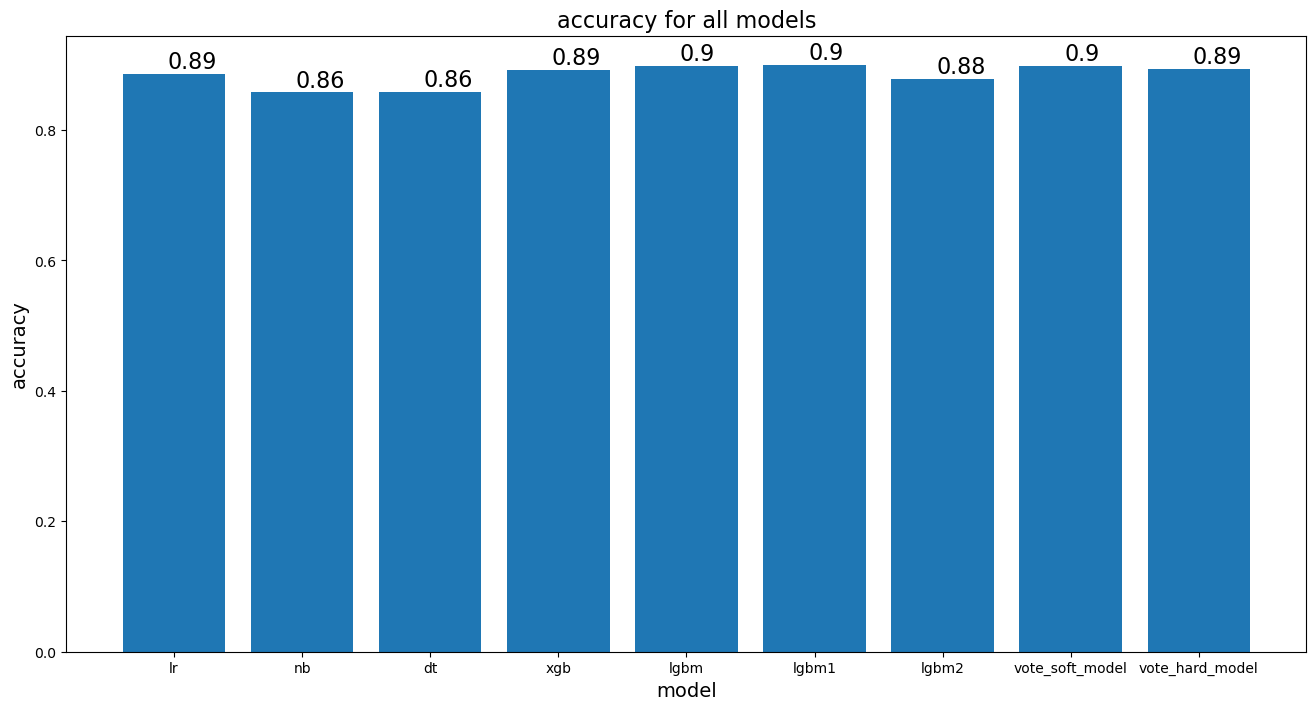

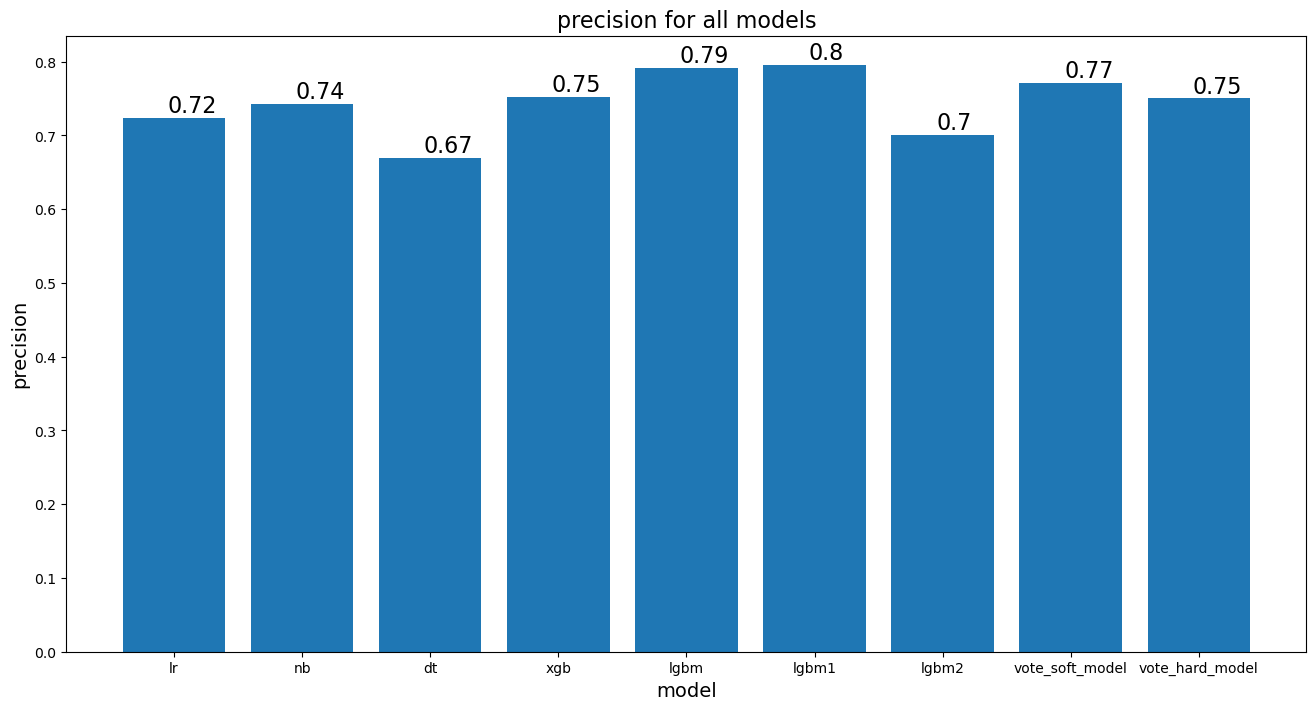

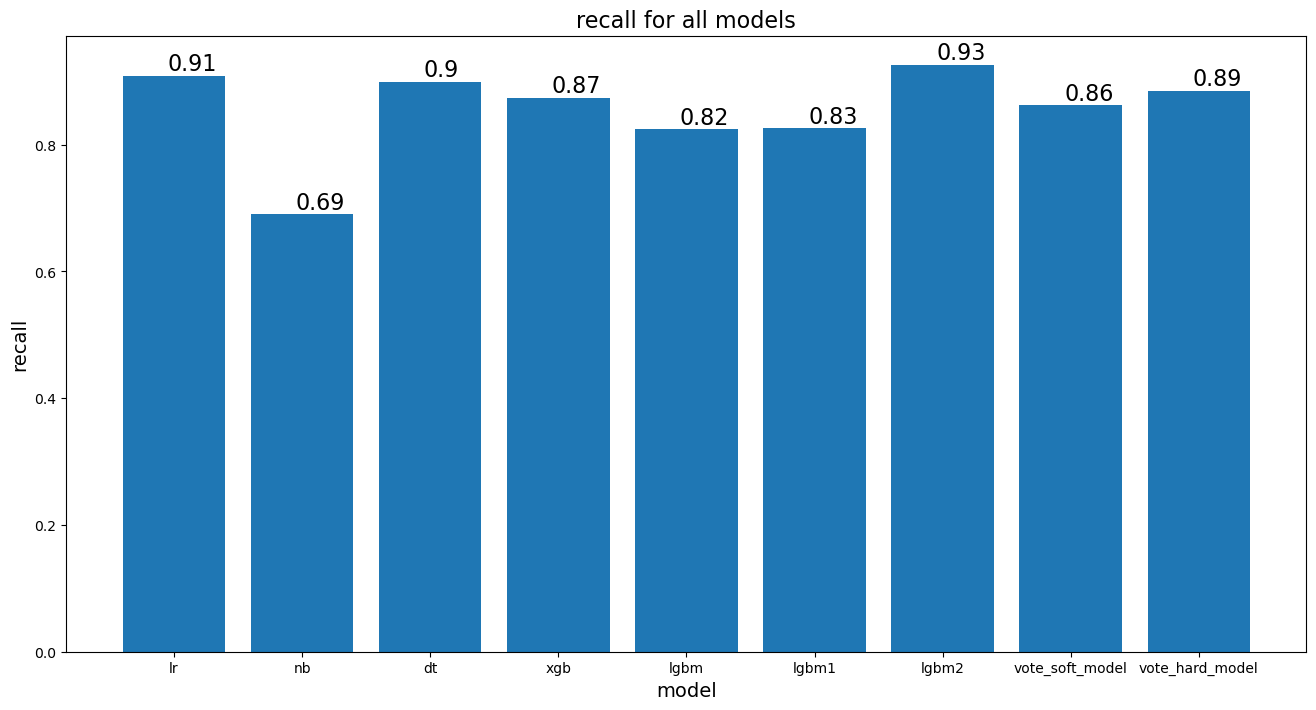

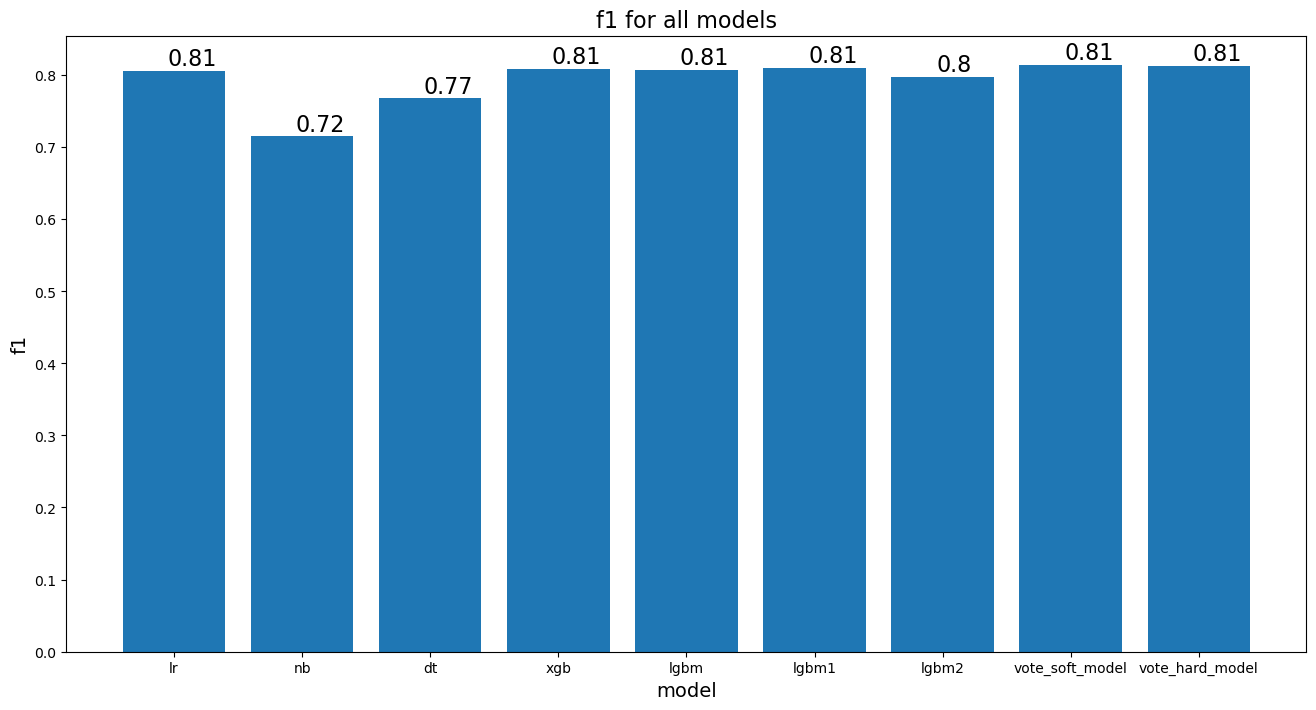

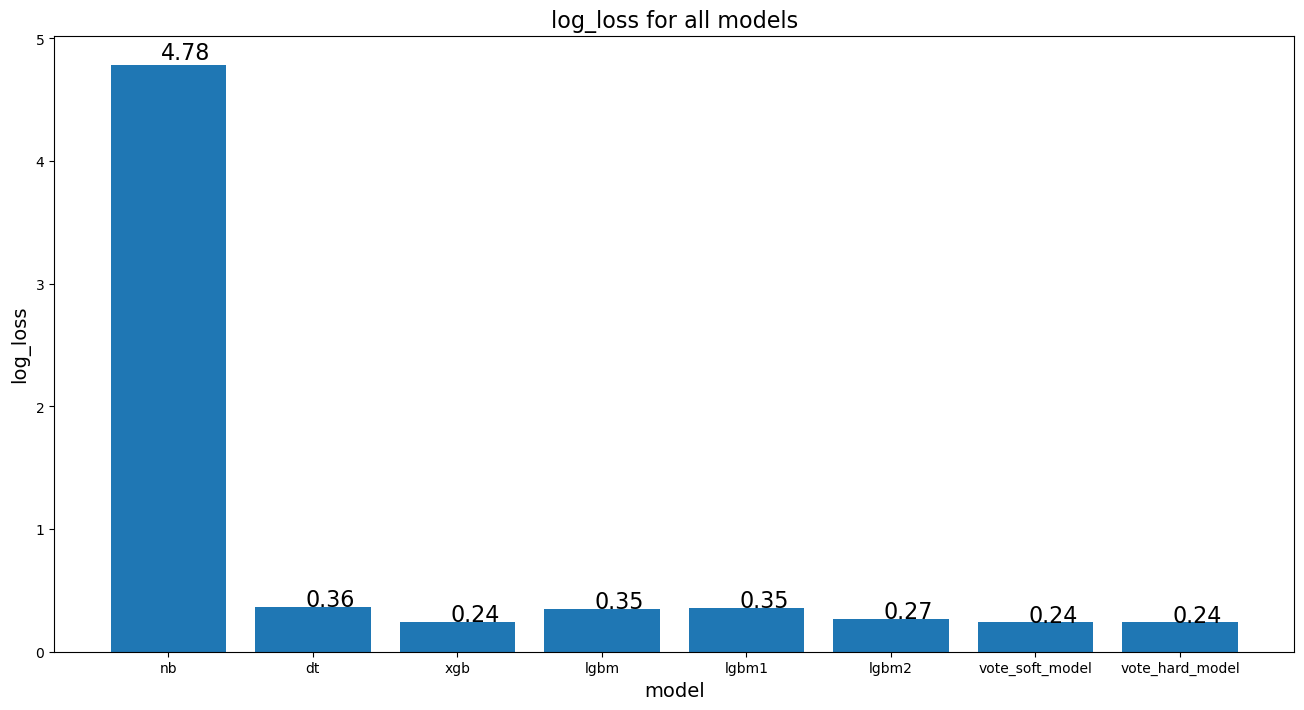

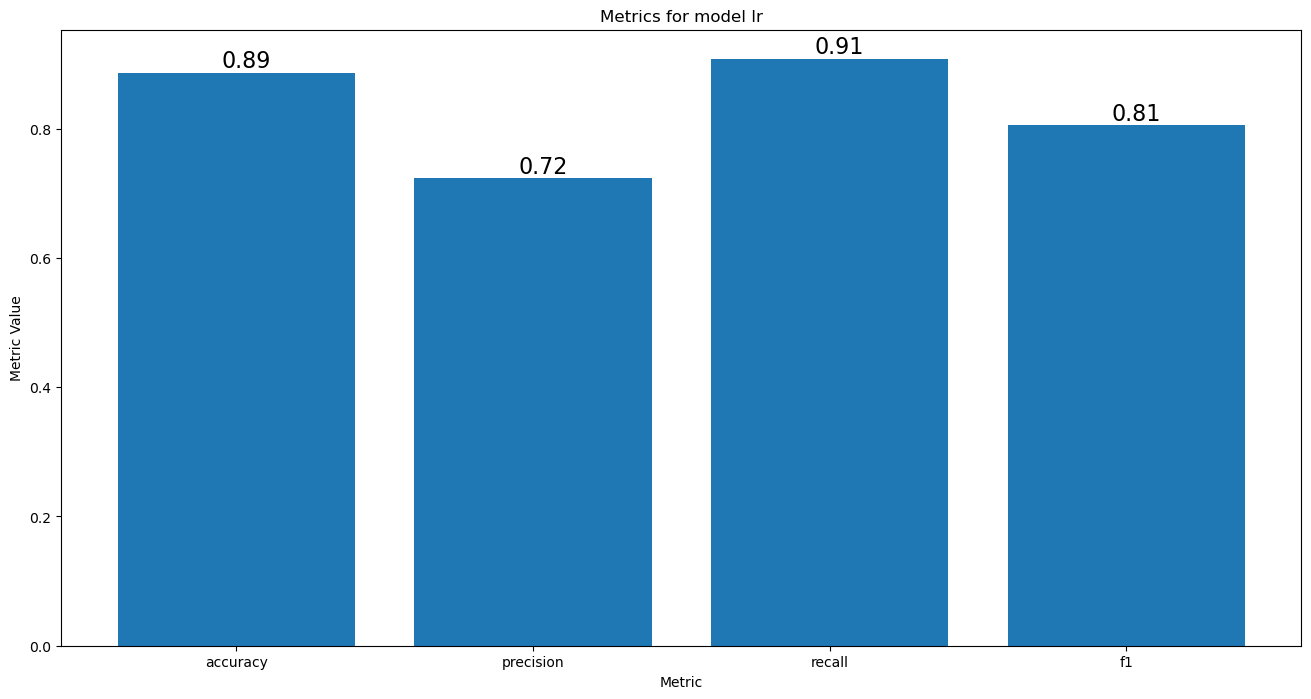

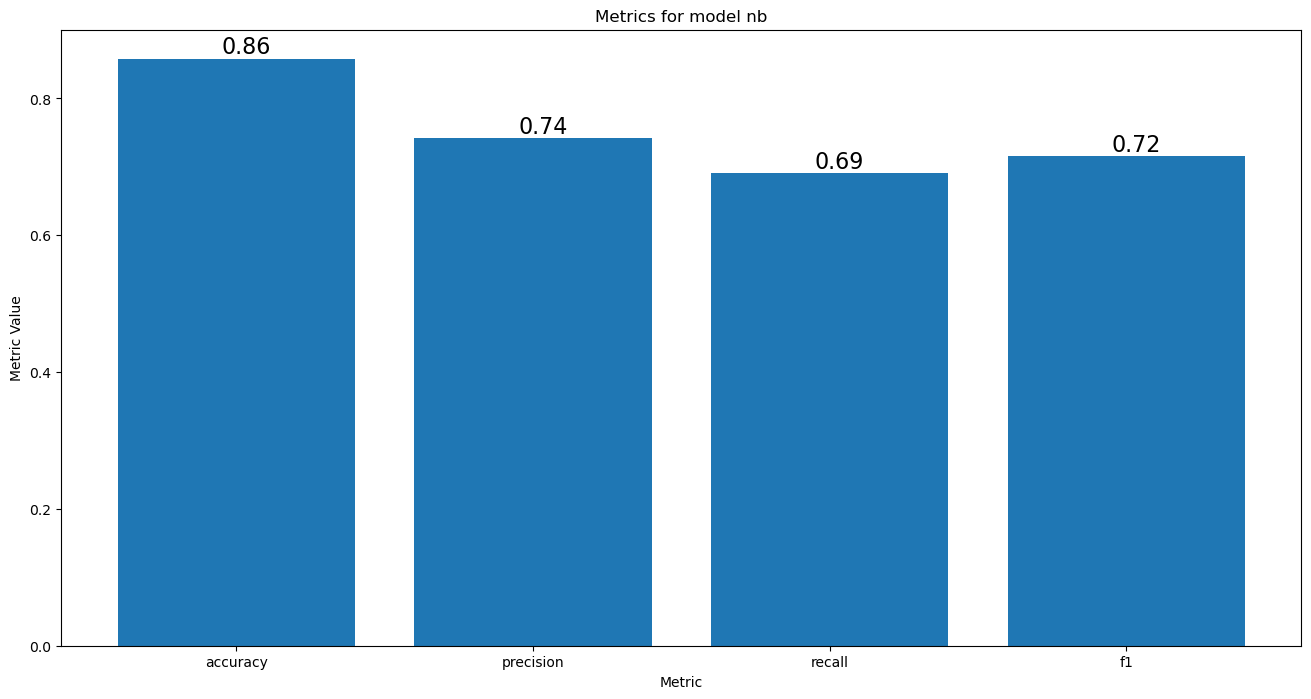

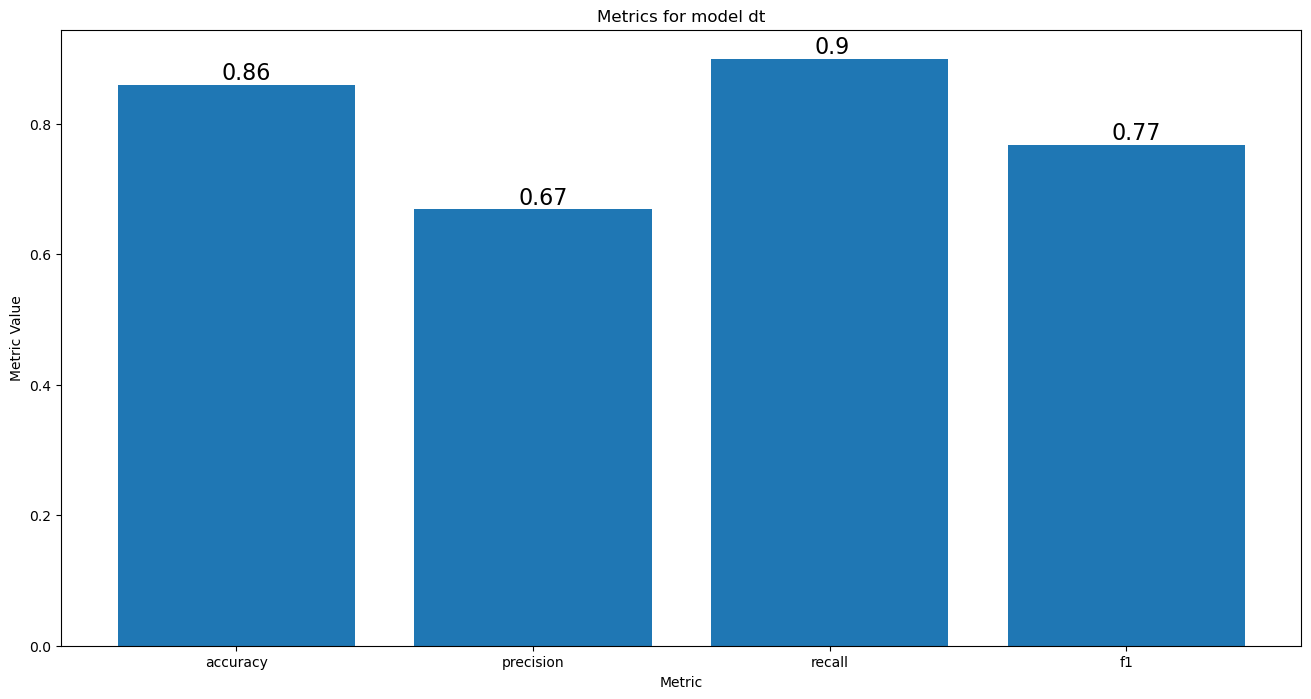

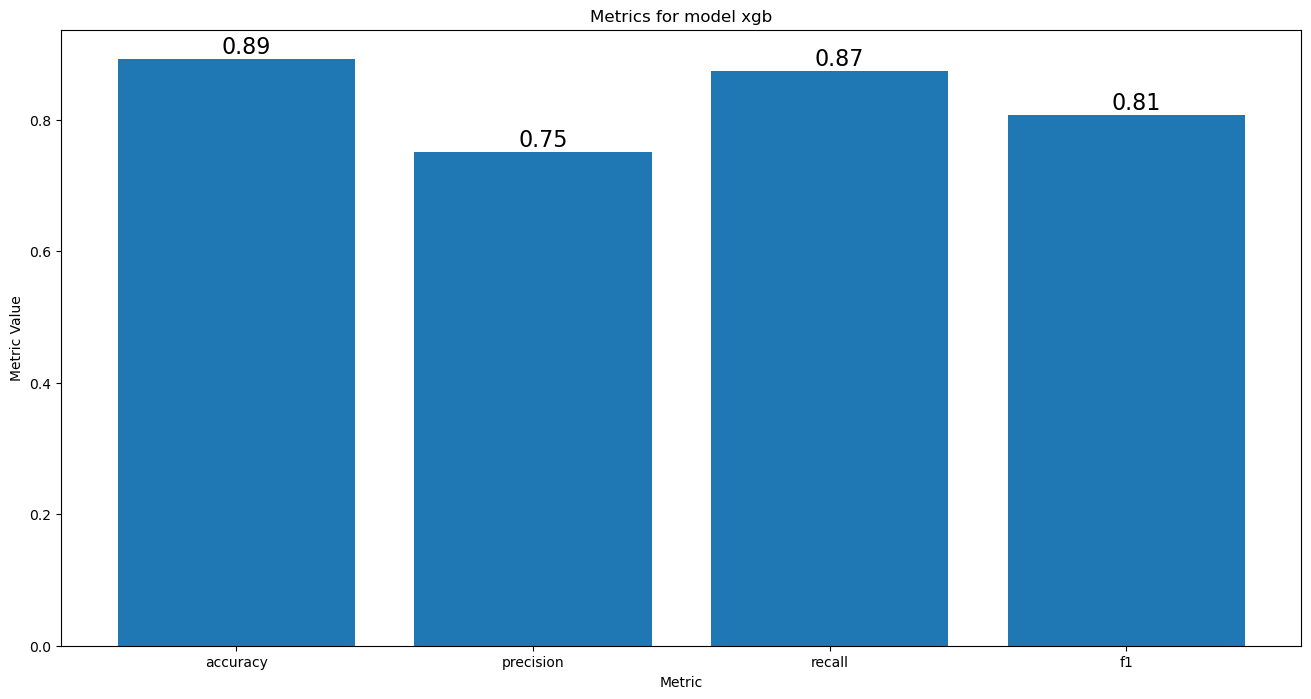

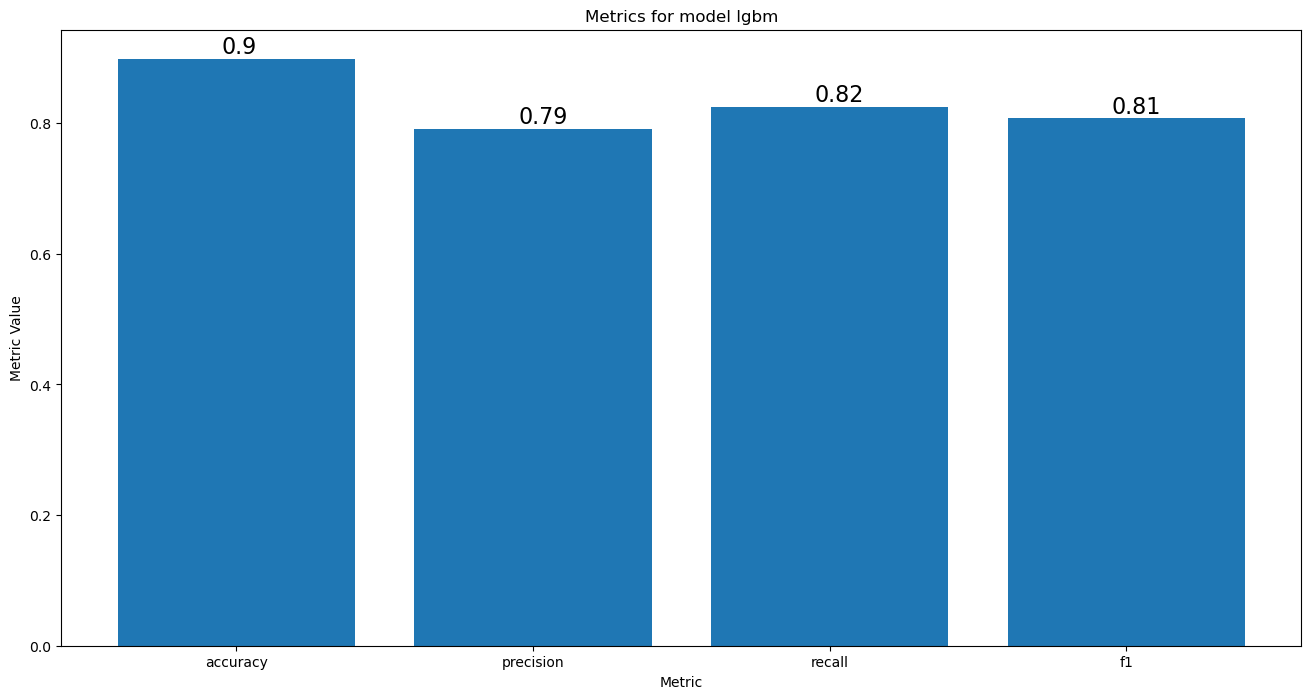

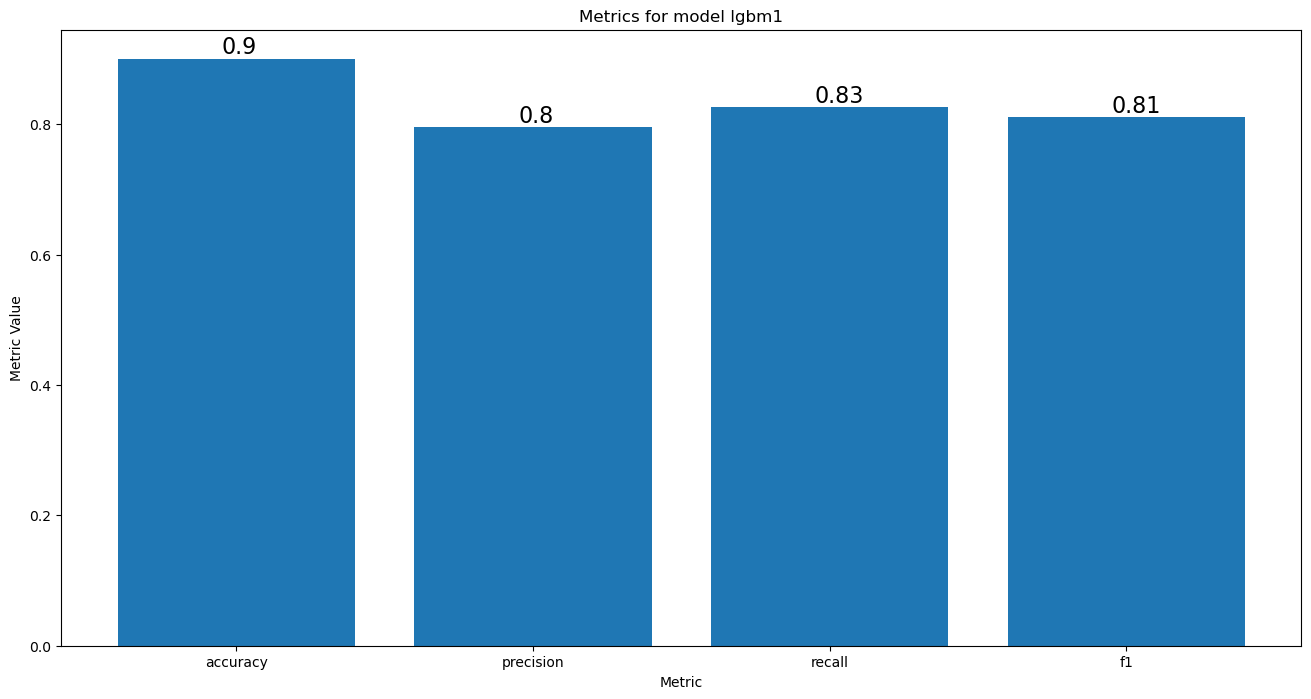

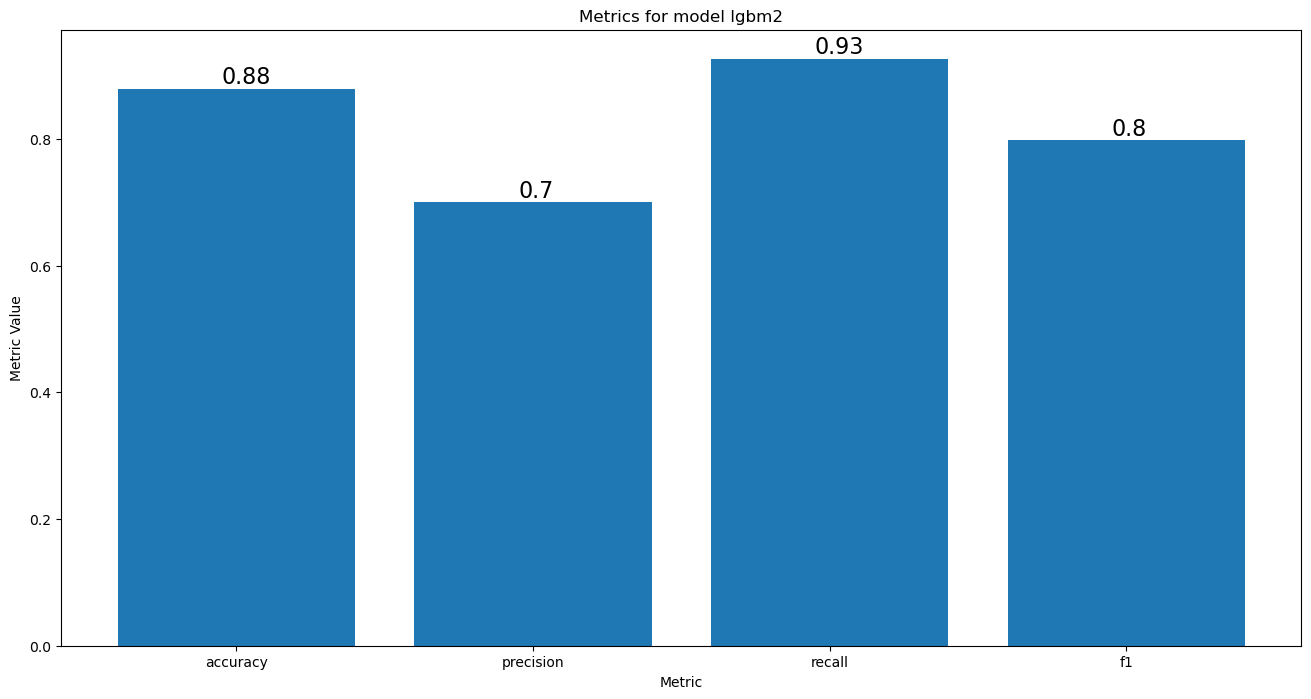

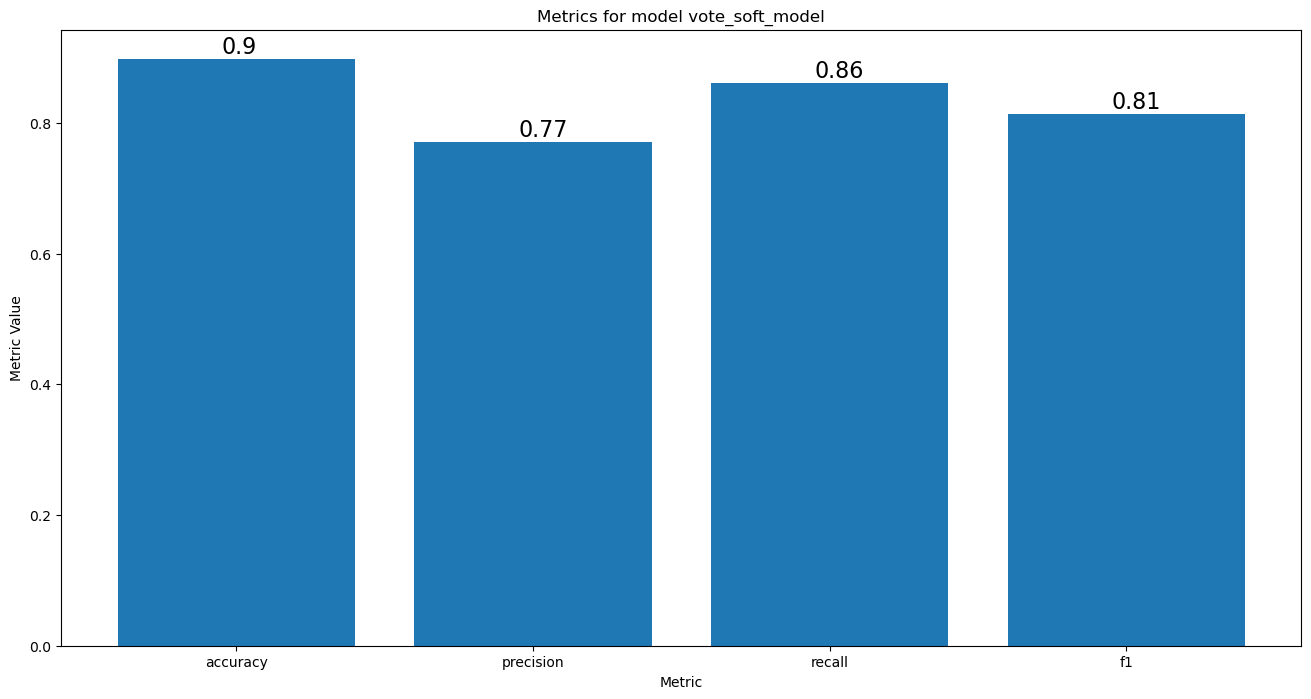

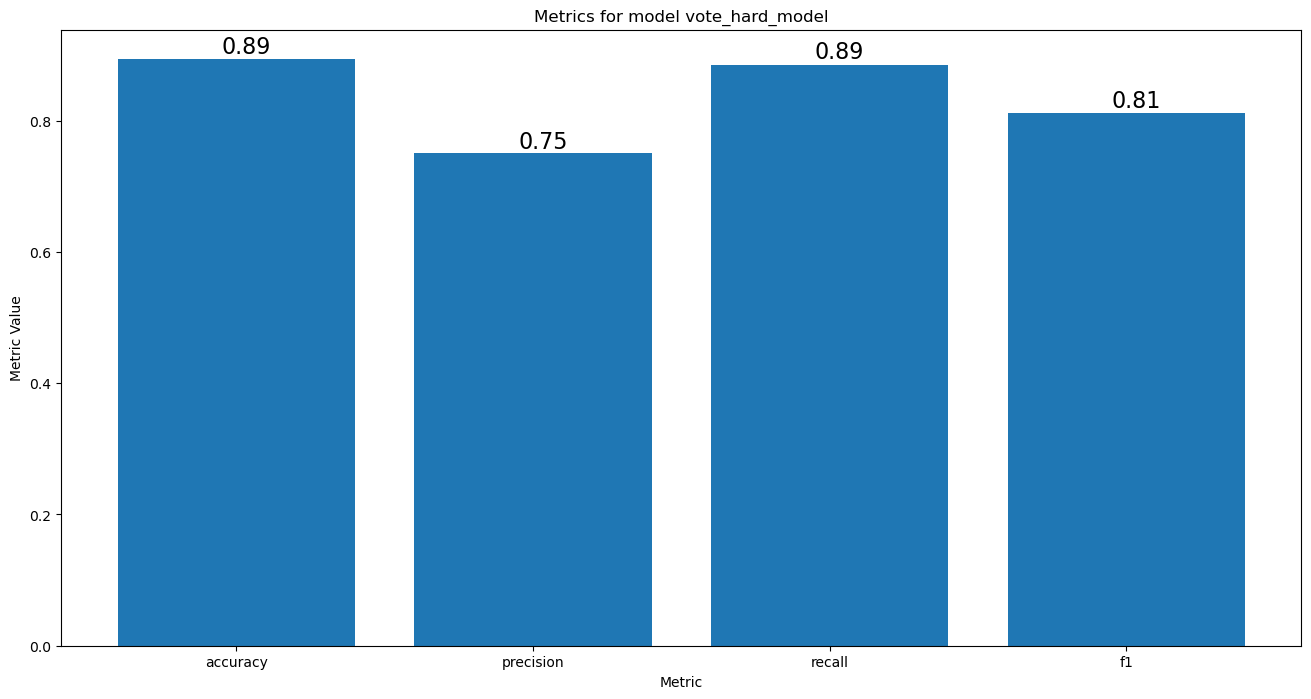

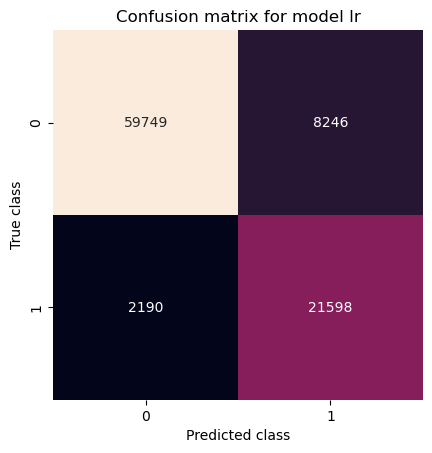

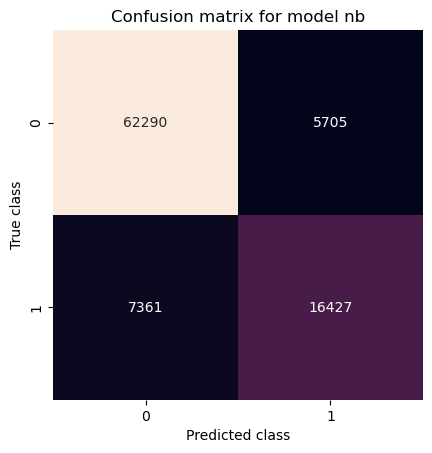

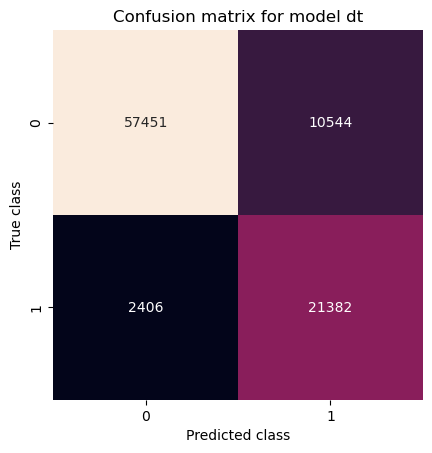

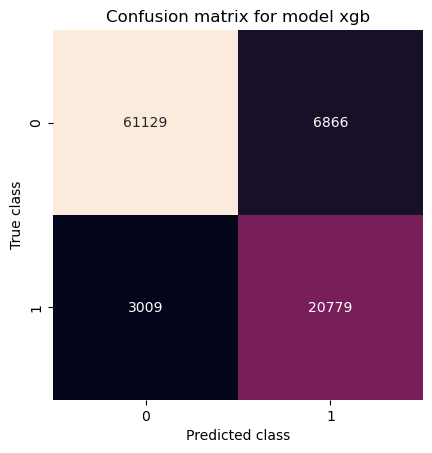

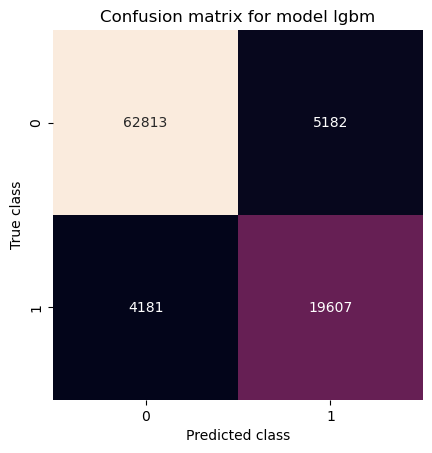

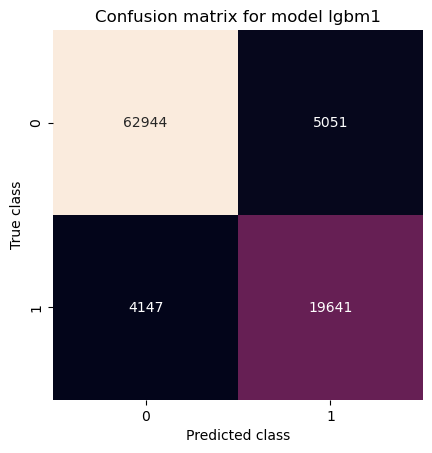

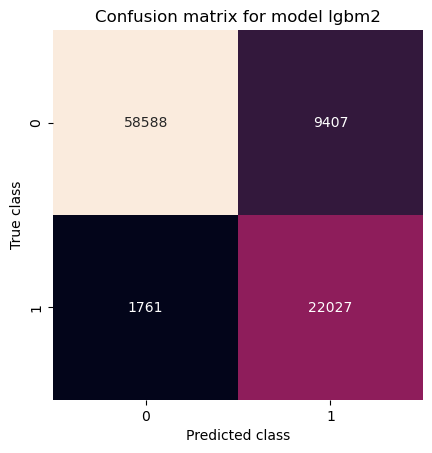

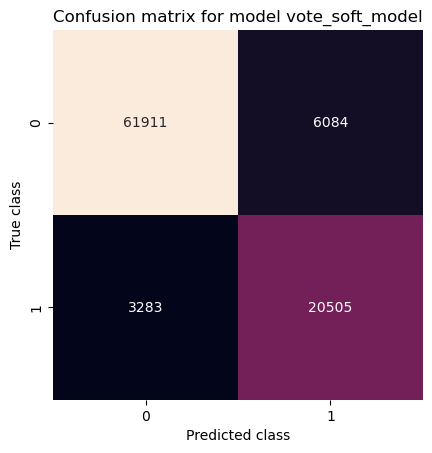

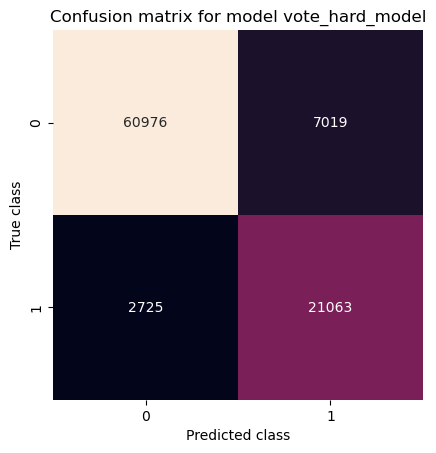

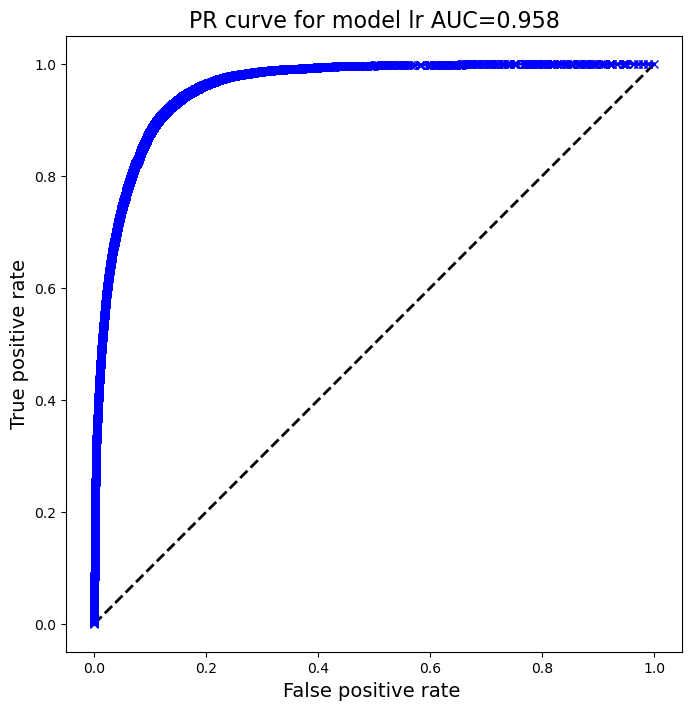

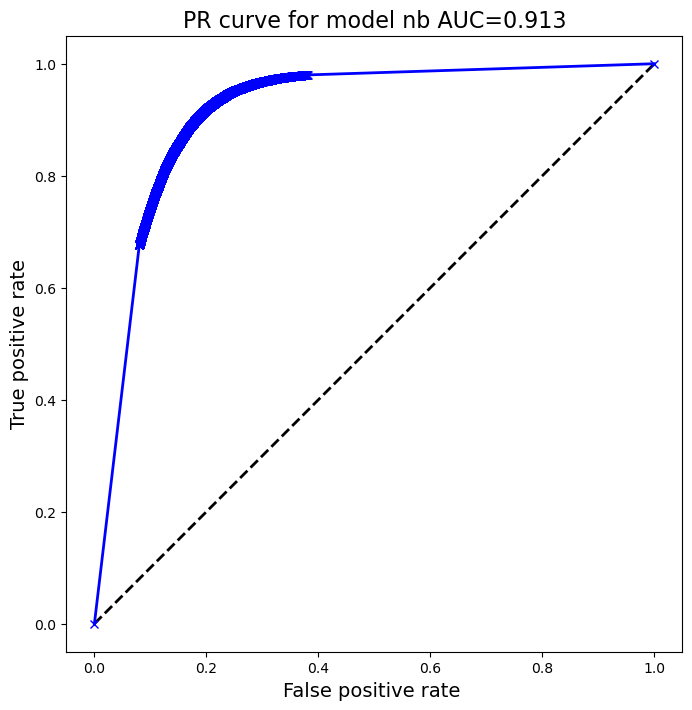

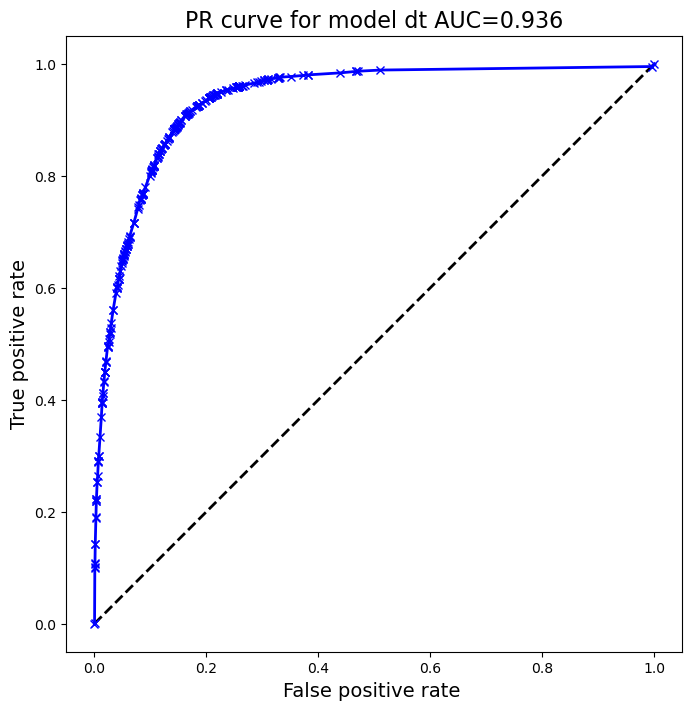

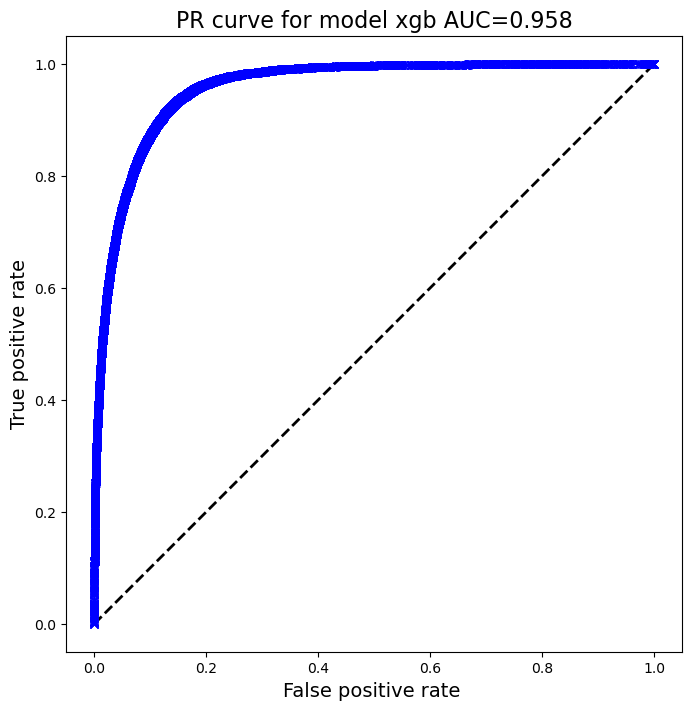

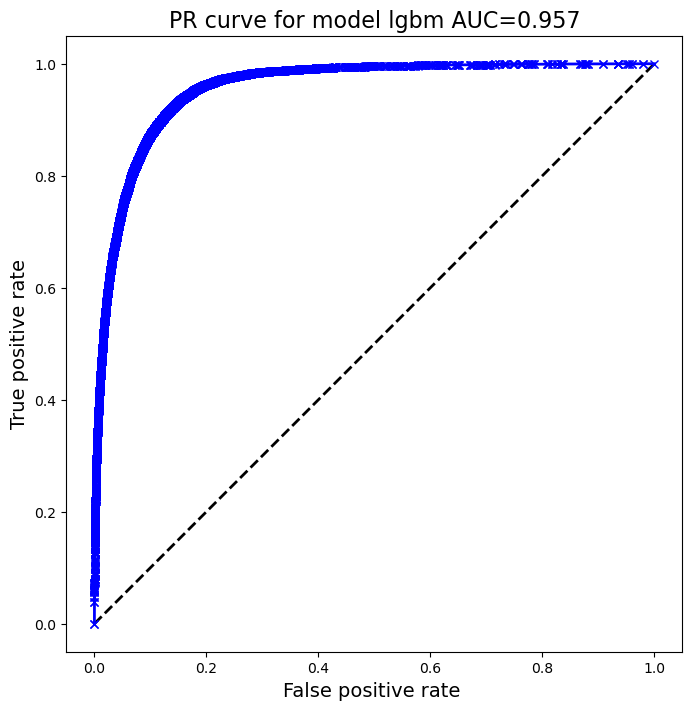

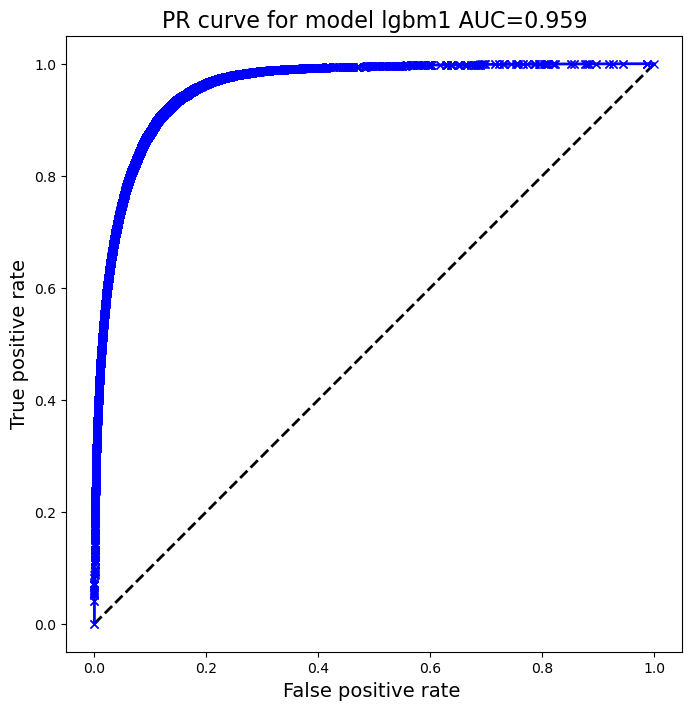

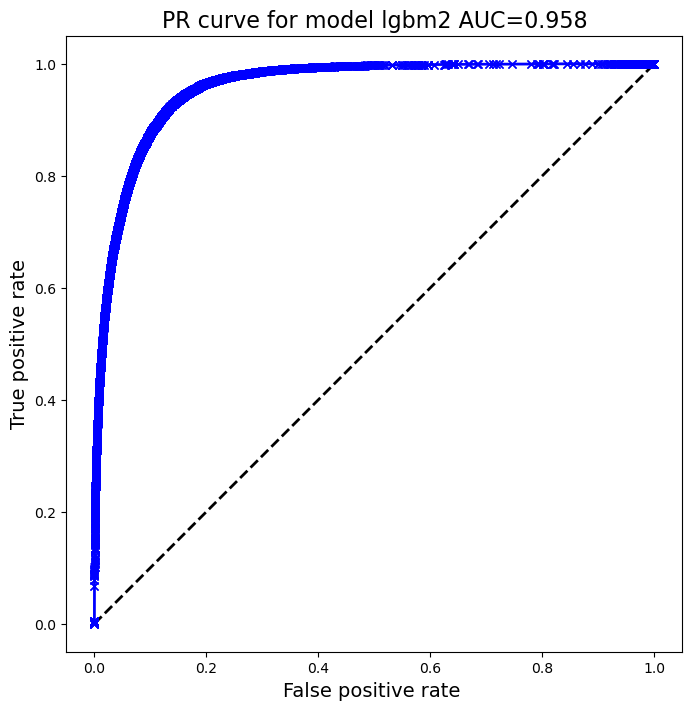

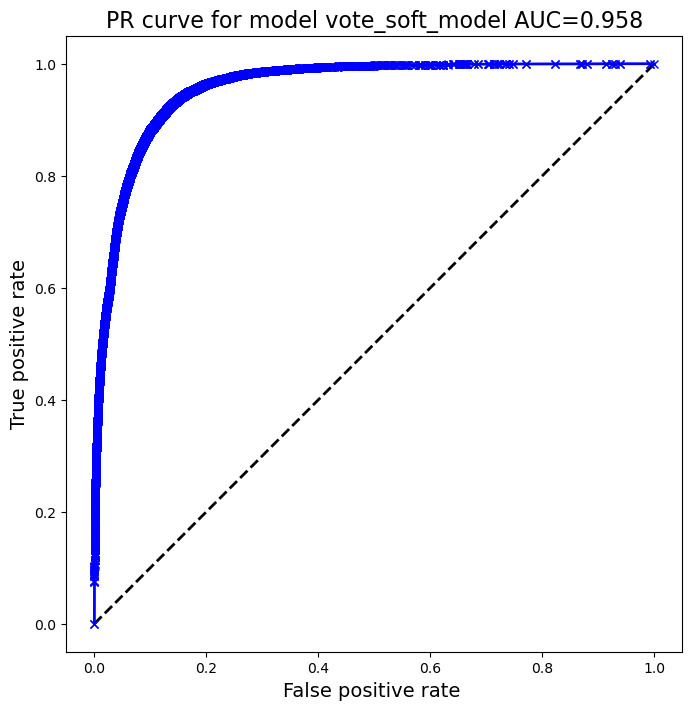

In [27]:

# vot model needs to be defined after models_list
*vc_list,      = zip(models_names,models_list)

# We set vot_soft_model.estimators_ in order to not train estimators again
# https://stackoverflow.com/questions/42920148/using-sklearn-voting-ensemble-with-partial-fit
vote_soft_model = VotingClassifier(estimators=vc_list,voting='soft')
vote_soft_model.estimators_ = models_list
vote_soft_model.le_         = LabelEncoder().fit(y_train)
vote_soft_model.classes_    = vote_soft_model.le_.classes_

vote_hard_model = VotingClassifier(estimators=vc_list,voting='hard')
vote_hard_model.estimators_ = models_list
vote_hard_model.estimators_ = models_list
vote_hard_model.le_         = LabelEncoder().fit(y_train)
vote_hard_model.classes_    = vote_hard_model.le_.classes_


# make a new list for voting models
# since models_lists was passed to vote_soft_model and vote_hard_model
# we are getting into problems of recursion, which deepcopy does not cure
# for now, treat voting models separately
voting_models_list  = [vote_soft_model,vote_hard_model]
voting_models_names = ['vote_soft_model','vote_hard_model']
proba_names.append('vote_soft_model')

save_models(voting_models_list,voting_models_names)

pred_dict      = pred_models_proba(models_list,models_names,proba_names,X_test)
pred_vote_dict = pred_models_proba(voting_models_list,voting_models_names,proba_names,X_test)
eval_dict      = eval_models(models_names,proba_names,y_test,pred_dict)
eval_vote_dict = eval_models(voting_models_names,proba_names,y_test,pred_vote_dict) 

combined_dict  = {**eval_dict,**eval_vote_dict}

print_results(combined_dict)    
plot_metrics(combined_dict,proba_names)

In [30]:
models_names=['xgb']
models_names

['xgb']

In [31]:
model_cnt=0
for model_name_ in models_names:
  print(model_name_)
  model_ = load_model(model_name_)
  ft_importance["Model"+str(model_cnt)]=model_.feature_importances_
  model_cnt=model_cnt+1


xgb


In [32]:
ft_importance

,Model0
P_2_mean,0.000987
P_2_std,0.000340
P_2_min,0.000552
P_2_max,0.000351
P_2_last,0.067422
...,...
R_28_last_mean_diff,0.000459
D_140_last_mean_diff,0.000451
D_143_last_mean_diff,0.000459
D_144_last_mean_diff,0.000470


In [33]:
ft_importance['avg']=ft_importance.mean(axis=1)

<AxesSubplot:>

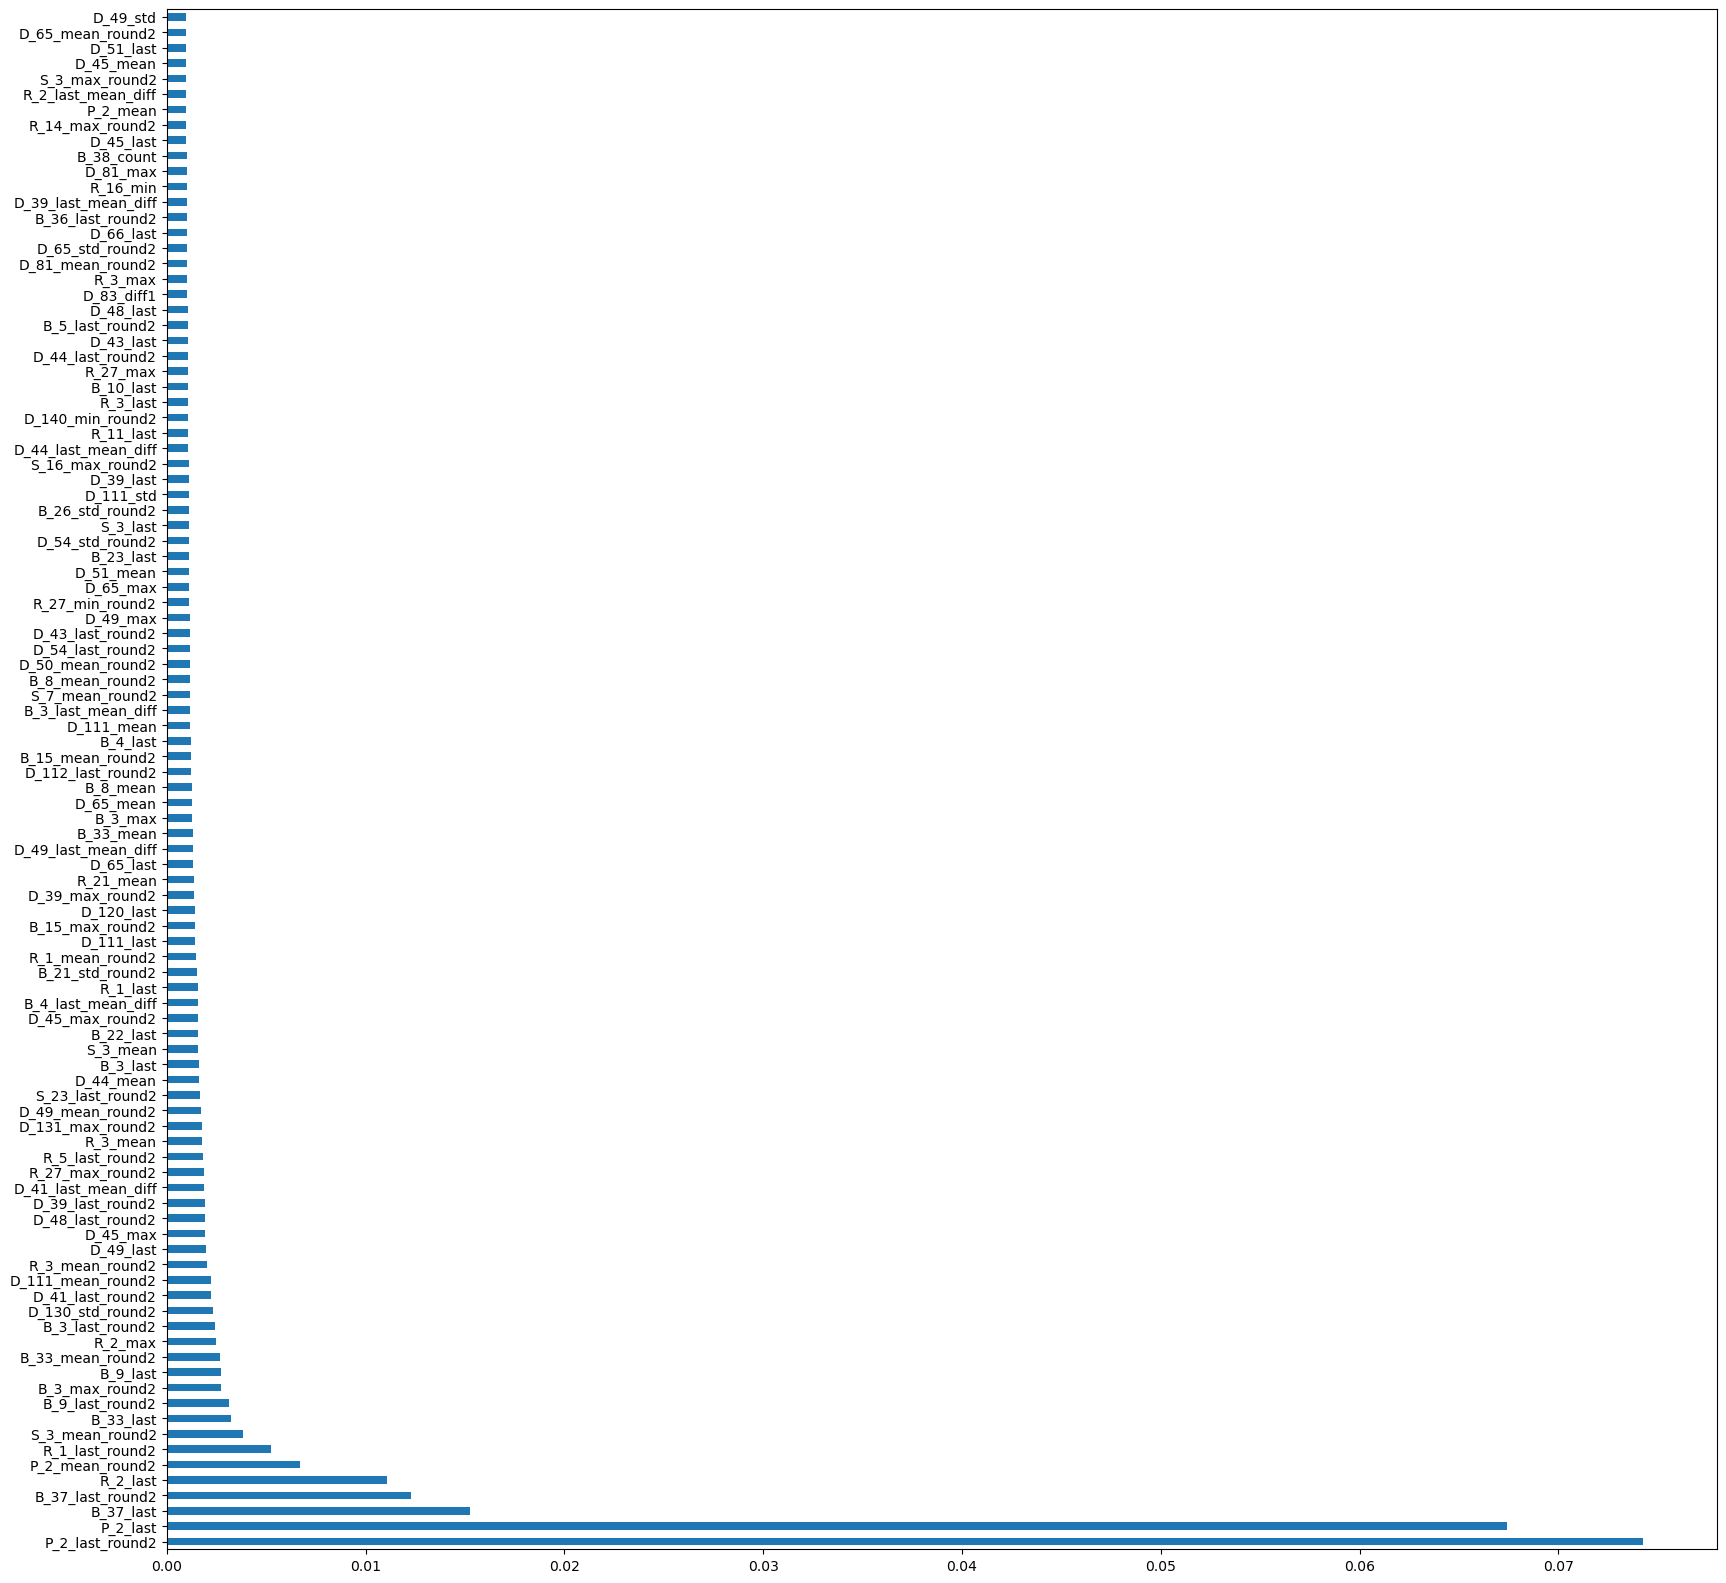

In [34]:
ft_importance=ft_importance['avg'].nlargest(100).sort_values(ascending=False)
fig, ax = plt.subplots()
ft_importance.plot.barh(x=ft_importance, y=ft_importance.index,figsize=(20, 20),ax=ax)

In [38]:
#fig.savefig('feature_importance.png')